In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import sys
sys.path.append('../../utils')
from preprocess import Preprocess
sys.path.append('../../config')
import matplotlib.pyplot as plt
from GlobalParams import MAX_SEQ_LEN

In [2]:
train_file = "total_train_data.csv"
data = pd.read_csv(train_file, delimiter=',')
# 데이터 구조 : 컬럼 2개(query, intent)
# query : 발화 내용
# intent : 발화 내용에 대한 label, 0~인사, 1~욕설, 2~주문, 3~예약, 4~기타
queries = data['query'].tolist()
intents = data['intent'].tolist()

In [3]:
# 전처리 객체
p = Preprocess(word2index_dic='../../train_tools/dict/chatbot_dict.bin',
               userdic='../../utils/user_dic.tsv')
# 단어 시퀀스 생성
sequences = []
for sentence in queries:
    pos = p.pos(sentence)
    keywords = p.pos(sentence)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

In [4]:
# 단어 시퀀스 벡터 생성
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# train, validation, test set 생성
dataset = tf.data.Dataset.from_tensor_slices((padded_seqs, intents))
dataset = dataset.shuffle(len(queries))

train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)

train_dataset = dataset.take(train_size).batch(20)
val_dataset = dataset.skip(train_size).take(val_size).batch(20)
test_dataset = dataset.skip(train_size + val_size).take(test_size).batch(20)

In [5]:
# 하이퍼 파라미터 설정
dropout_prob = 0.3 # 0.5에서 수정
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = len(p.word_index) + 1

In [6]:
# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)
# 3-gram / conv 층 추가
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
conv1_1 = Conv1D(filters=256, kernel_size=3, padding='valid', activation=tf.nn.relu)(conv1)
conv1_2 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(conv1_1)
pool1 = GlobalMaxPool1D()(conv1_2)
# 4-gram / conv 층 추가
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
conv2_1 = Conv1D(filters=256, kernel_size=4, padding='valid', activation=tf.nn.relu)(conv2)
conv2_2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(conv2_1)
pool2 = GlobalMaxPool1D()(conv2_2)
# 5-gram / conv 층 추가
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
conv3_1 = Conv1D(filters=256, kernel_size=5, padding='valid', activation=tf.nn.relu)(conv3)
conv3_2 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(conv3_1)
pool3= GlobalMaxPool1D()(conv3_2)

concat = concatenate([pool1, pool2, pool3])

hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [7]:
# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
checkpoint = ModelCheckpoint('./intent_classification_best_model.h5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00005),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=EPOCH, verbose=1,callbacks=checkpoint)

loss, acc = model.evaluate(test_dataset, verbose=1)
print("ACC : %f"%(acc*100))
print("LOSS : %f"%loss)

Epoch 1/30
3697/3698 [============================>.] - ETA: 0s - loss: 0.8008 - accuracy: 0.5936
Epoch 00001: val_accuracy improved from -inf to 0.63244, saving model to ./intent_classification_best_model.h5
3698/3698 [==============================] - 50s 14ms/step - loss: 0.8007 - accuracy: 0.5936 - val_loss: 0.7440 - val_accuracy: 0.6324
Epoch 2/30
3696/3698 [============================>.] - ETA: 0s - loss: 0.7570 - accuracy: 0.6201
Epoch 00002: val_accuracy did not improve from 0.63244
3698/3698 [==============================] - 49s 13ms/step - loss: 0.7570 - accuracy: 0.6201 - val_loss: 0.7364 - val_accuracy: 0.6313
Epoch 3/30
3695/3698 [============================>.] - ETA: 0s - loss: 0.7496 - accuracy: 0.6244
Epoch 00003: val_accuracy did not improve from 0.63244
3698/3698 [==============================] - 49s 13ms/step - loss: 0.7496 - accuracy: 0.6243 - val_loss: 0.7396 - val_accuracy: 0.6264
Epoch 4/30
3696/3698 [============================>.] - ETA: 0s - loss: 0.7484 -

Text(0.5, 1.0, 'loss')

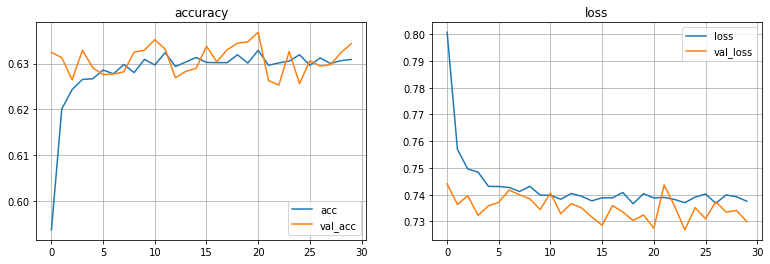

In [8]:
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid()
plt.title(f'accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()
plt.title(f'loss')

In [18]:
y_pred = model.predict(test_dataset)
y_pred_list = np.argmax(y_pred, axis=1)
y_pred_list

array([4, 4, 3, ..., 3, 3, 3])

In [30]:
len(y_pred_list)

10565

In [38]:
y_true_list = []
for _ ,datas in test_dataset.as_numpy_iterator():
    for data in datas:
        y_true_list.append(data)
print(len(y_true_list))

10565


<AxesSubplot:>

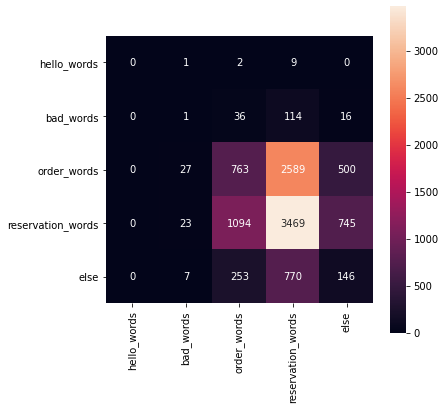

In [42]:
# confusion matrix
category = ['hello_words', 'bad_words', 'order_words', 'reservation_words', 'else']
confusion = confusion_matrix(y_true_list, y_pred_list)
fig = plt.figure(figsize = (6, 6))
sns.heatmap(confusion, annot = True, fmt = 'd', xticklabels = category, yticklabels = category, square = True)

In [ ]:
# 교재 제공 모델 정확도 테스트